In [1]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae, mape, rmse
nixtla_client = NixtlaClient(
    api_key = 'nixak-ZUBNbtRWb0JinHdA6NlRvMZkmH1YU7knytR4yi0JkGaBULEdSgElW5bKVIjf6RcXGdOSijcJSxAYvwzq'
)

nixtla_client.validate_api_key()


INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

In [2]:
import pandas as pd
from datetime import timedelta
from nixtla import NixtlaClient
from utilsforecast.losses import mae

In [3]:
df = pd.read_csv('df.csv')
df["unique_id"] = 0
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True, drop=False)

In [4]:
h = 24                              # hours ahead each run
context_days = 60                   # days of history
start_date = pd.Timestamp('2023-01-01')
end_date   = pd.Timestamp('2023-12-31')

In [5]:
all_fcsts = []
current = start_date
while current <= end_date:
    # build the context window [current - context_days, current)
    window_end   = current - timedelta(hours=1)
    window_start = window_end - timedelta(days=context_days)
    hist = df.loc[window_start : window_end].reset_index(drop=True)
    
    # run a 24h forecast from current → current+23h
    fcst = nixtla_client.forecast(
        df            = hist,
        h             = h,
        level         = [90],
        finetune_steps= 10,
        finetune_loss = "mae",
        model         = "timegpt-1-long-horizon",
        id_col        = "unique_id",
        time_col      = "time",
        target_col    = "DAP",
    )
    
    all_fcsts.append(fcst)
    current += timedelta(days=1)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
/Users/natowei/ConcordNewEnergy/myenv/lib/python3.12/site-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['DAP 24H', 'DAP 7D', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew', 'is_holiday'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: h
/Users/natowei/ConcordNewEnergy/myenv/lib/python3.12/site-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['DAP 24H', 'DAP 7D', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew', 'is_holiday'], but `X_df` was not provided and they were not declared in `hist_exog_li

In [6]:
pred_df = pd.concat(all_fcsts, ignore_index=True)

In [9]:
pred_df

,unique_id,time,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
0,0,2023-01-01 00:00:00,-15.721246,65.442560,-96.885050
1,0,2023-01-01 01:00:00,-13.933078,54.482820,-82.348970
2,0,2023-01-01 02:00:00,-13.835656,61.644410,-89.315720
3,0,2023-01-01 03:00:00,-12.041926,49.647087,-73.730940
4,0,2023-01-01 04:00:00,-12.573987,64.095940,-89.243920
...,...,...,...,...,...
8755,0,2023-12-31 19:00:00,21.250242,25.045916,17.454569
8756,0,2023-12-31 20:00:00,20.425410,22.920048,17.930770
8757,0,2023-12-31 21:00:00,18.674498,21.931728,15.417267
8758,0,2023-12-31 22:00:00,17.029356,20.591436,13.467276


In [10]:
df2 = df.reset_index(drop=True)
mask = df2['time'].isin(pred_df['time'])

actual = df2.loc[mask, ['unique_id','time','DAP']]


In [24]:
merged = actual.merge(
    pred_df[['unique_id','time','TimeGPT', 'TimeGPT-hi-90', 'TimeGPT-lo-90']],
    on=['unique_id','time'],
    how='inner'
)

evaluation = mae(
    merged,
    models     = ["TimeGPT"],
    id_col     = "unique_id",
    target_col = "DAP"
)
print("Year-long MAE:", evaluation)


Year-long MAE:    unique_id    TimeGPT
0          0  39.986153


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_day_forecast(date_str, merged_df, model_name='TimeGPT'):
    """
    Plots actual vs. predicted values with a 90% confidence interval
    for a single 24-hour period specified by `date_str` (YYYY-MM-DD).
    """
    # Convert date_str to datetime and define the 24h range
    date = pd.to_datetime(date_str).normalize()
    next_date = date + pd.Timedelta(days=1)

    # Select only the rows for that day
    mask = (merged_df['time'] >= date) & (merged_df['time'] < next_date)
    df_day = merged_df.loc[mask].copy()
    if df_day.empty:
        raise ValueError(f"No data for {date_str}")

    # Use the known CI column names for 90%
    lower_col = f"{model_name}-lo-90"
    upper_col = f"{model_name}-hi-90"
    if lower_col not in df_day.columns or upper_col not in df_day.columns:
        raise ValueError(
            f"Expected columns '{lower_col}' and '{upper_col}' not both found. "
            f"Available columns: {df_day.columns.tolist()}"
        )

    # Plot
    plt.figure()
    plt.plot(df_day['time'], df_day['DAP'],      label='Actual')
    plt.plot(df_day['time'], df_day[model_name], label='Prediction')
    plt.fill_between(
        df_day['time'],
        df_day[lower_col],
        df_day[upper_col],
        alpha=0.3,
        label='90% CI'
    )
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('DAP')
    plt.title(f"{model_name} Forecast vs Actual: {date.date()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

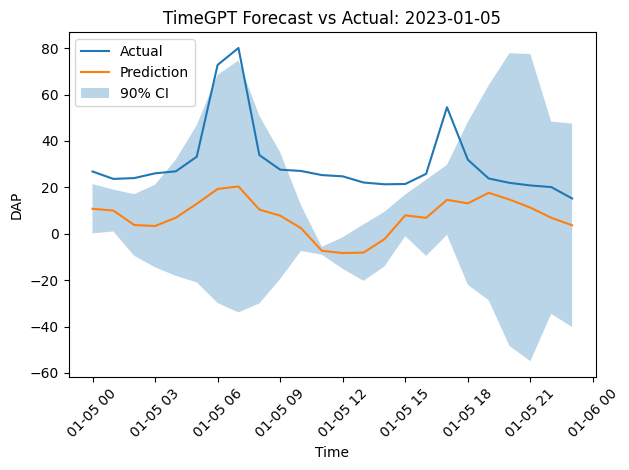

In [35]:
plot_day_forecast('2023-01-05', merged)


In [32]:
merged

,unique_id,time,DAP,TimeGPT,TimeGPT-hi-90,TimeGPT-lo-90
0,0,2023-01-01 00:00:00,10.83340,-15.721246,65.442560,-96.885050
1,0,2023-01-01 01:00:00,10.22220,-13.933078,54.482820,-82.348970
2,0,2023-01-01 02:00:00,8.73719,-13.835656,61.644410,-89.315720
3,0,2023-01-01 03:00:00,8.19749,-12.041926,49.647087,-73.730940
4,0,2023-01-01 04:00:00,8.33215,-12.573987,64.095940,-89.243920
...,...,...,...,...,...,...
8755,0,2023-12-31 19:00:00,19.37150,21.250242,25.045916,17.454569
8756,0,2023-12-31 20:00:00,16.77390,20.425410,22.920048,17.930770
8757,0,2023-12-31 21:00:00,15.00350,18.674498,21.931728,15.417267
8758,0,2023-12-31 22:00:00,15.76990,17.029356,20.591436,13.467276


In [33]:
merged.to_csv('TimesGPT_SingleVar.csv', index=False)
